In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import pandas as pd
import numpy as np

In [4]:
stock_df = pd.read_csv("C:/Users/maxfi/Downloads/TSLA.csv")

In [5]:
del stock_df['Adj Close']
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

In [6]:
stock_df

,Date,Open,High,Low,Close,Volume
0,2019-01-22,60.964001,61.599998,59.099998,59.784000,60333500
1,2019-01-23,58.500000,58.900002,56.338001,57.518002,62650000
2,2019-01-24,56.605999,58.736000,55.855999,58.301998,40061000
3,2019-01-25,58.877998,59.703999,57.910000,59.408001,36248000
4,2019-01-28,58.582001,59.492001,57.549999,59.276001,32116500
...,...,...,...,...,...,...
753,2022-01-14,1019.880005,1052.000000,1013.380005,1049.609985,24246600
754,2022-01-18,1026.609985,1070.790039,1016.059998,1030.510010,22247800
755,2022-01-19,1041.709961,1054.670044,995.000000,995.650024,25147500
756,2022-01-20,1009.729980,1041.660034,994.000000,996.270020,23496200


In [7]:
from singleFeatureLearnerTree.GYM_single_stock_indicators import DerivativesTradingEnv

In [8]:
n_lookback = 30
learning_length = 632 # trading year is 253 days
data_df = stock_df.iloc[-(learning_length + n_lookback):].drop("Date", axis=1)

In [9]:
ignore_indicators = [
    'volatility_kcc', 'trend_sma_slow', 'momentum_wr', 'others_dr', # highly correlated with other indicators
    
    'volatility_kch', 'trend_ichimoku_conv', 'volume_adi', 'momentum_rsi',
       'trend_macd_diff', 'Open', 'trend_vortex_ind_pos', 'volatility_kcli',
       'volume_sma_em', 'volatility_bbli', 'others_cr', 'momentum_ppo_hist',
       'trend_stc', 'volume_cmf', 'momentum_stoch_rsi_d', 'volatility_ui',
       'momentum_stoch_rsi', 'volatility_dcw', 'trend_aroon_ind',
       'momentum_pvo_hist', 'trend_macd_signal', 'trend_ema_fast', 'High',
       'trend_kst', 'trend_kst_diff', 'trend_mass_index',
       'momentum_stoch_rsi_k', 'volatility_bbm', 'momentum_pvo_signal',
       'trend_ichimoku_b'
]

In [10]:
train_env = DerivativesTradingEnv(data_df, train_end_ratio=0.80, n_lookback=n_lookback, ignore_indicators=ignore_indicators)

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float16
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [11]:
train_env.get_state_column_names()

Index(['Low', 'volume_obv', 'volume_fi', 'volume_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcp',
       'volatility_atr', 'trend_macd', 'trend_sma_fast', 'trend_ema_slow',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_dpo', 'trend_kst_sig', 'trend_ichimoku_base', 'trend_ichimoku_a',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_psar_up', 'trend_psar_down',
       'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_ao',
       'momentum_roc', 'momentum

In [12]:
from singleFeatureLearnerTree.train_CDT import run as train_CDT
import torch

In [28]:
learner_args = { # 2592 feature learner params
    "num_intermediate_variables"    : 5,
    "feature_learning_depth"        : 3,
    "beta_fl"                       : 1,
    "decision_depth"                : 4,
    "lr"                            : 2e-3,
    "K_epoch"                       : 40,
    "weight_decay"                  : 0.001,
    "gamma"                         : 0.0,
    "exp_scheduler_gamma"           : 1.,
    "device"                        : "cpu", # "cuda:0" if torch.cuda.is_available() else 
    "greatest_path_probability"     : 0,
    "beta_dc"                       : 1,
    "classification"                : 1,
    "clip_sample_weights"           : [0.5, 2.],
    "learn_probabilities"           : 1,
    "max_loss_for_weight"           : None,
    "fixed_model_weight"            : 1,
    "loss_batch_size"               : 10,
}

In [29]:
model, data, train, validation = train_CDT(train_env, learner_args, train=True)

55 3


In [30]:
train_losses_lst = []
val_losses_lst = []
for i in range(20):
    model, _, _, _ = train_CDT(train_env, learner_args, train=True, reuse_data=data)
    train_losses_lst.append(model.train_losses)
    val_losses_lst.append(model.val_losses)

55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3
55 3


In [31]:
import numpy as np
train_losses_avg = np.average(train_losses_lst, axis=0)
train_losses_std = np.std(train_losses_lst, axis=0)
val_losses_avg = np.average(val_losses_lst, axis=0)
val_losses_std = np.std(val_losses_lst, axis=0)

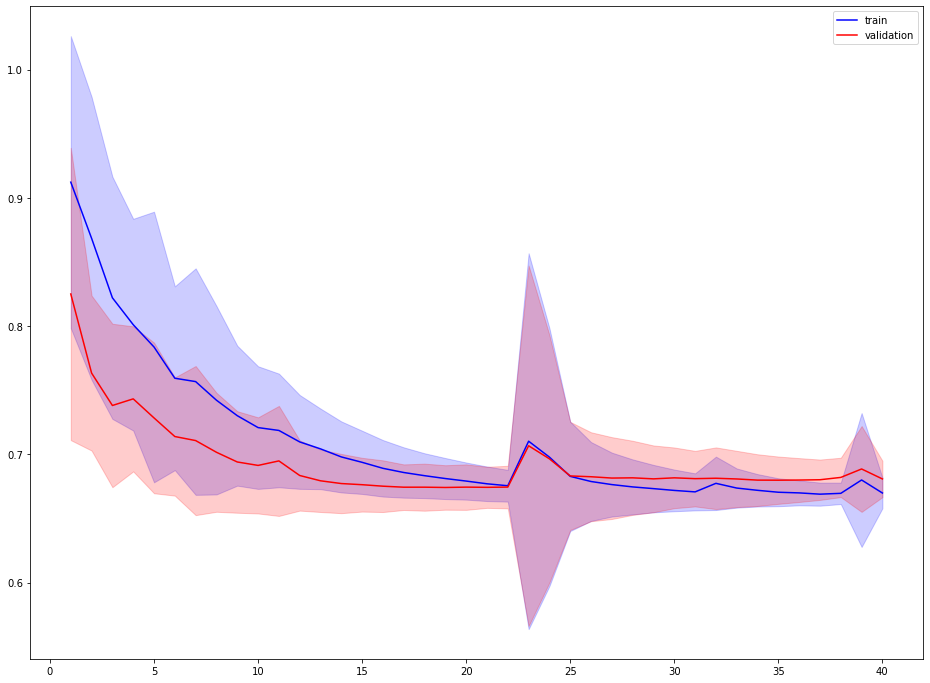

In [33]:
import matplotlib.pyplot as plt
# loss batch size of 10
plt.rcParams["figure.figsize"] = [16,12]

plt.plot(range(1, 41), train_losses_avg, label="train", color='blue')
# plt.errorbar(range(1, 101), train_losses_avg, yerr=train_losses_std, color='blue')
plt.fill_between(range(1, 41), train_losses_avg+train_losses_std, train_losses_avg-train_losses_std, alpha=0.2, color='blue')

plt.plot(range(1, 41), val_losses_avg, label="validation", color='red')
# plt.errorbar(range(1, 101), val_losses_avg, yerr=val_losses_std, color='red')
plt.fill_between(range(1, 41), val_losses_avg+val_losses_std, val_losses_avg-val_losses_std, alpha=0.2, color='red')

plt.legend(loc="best")

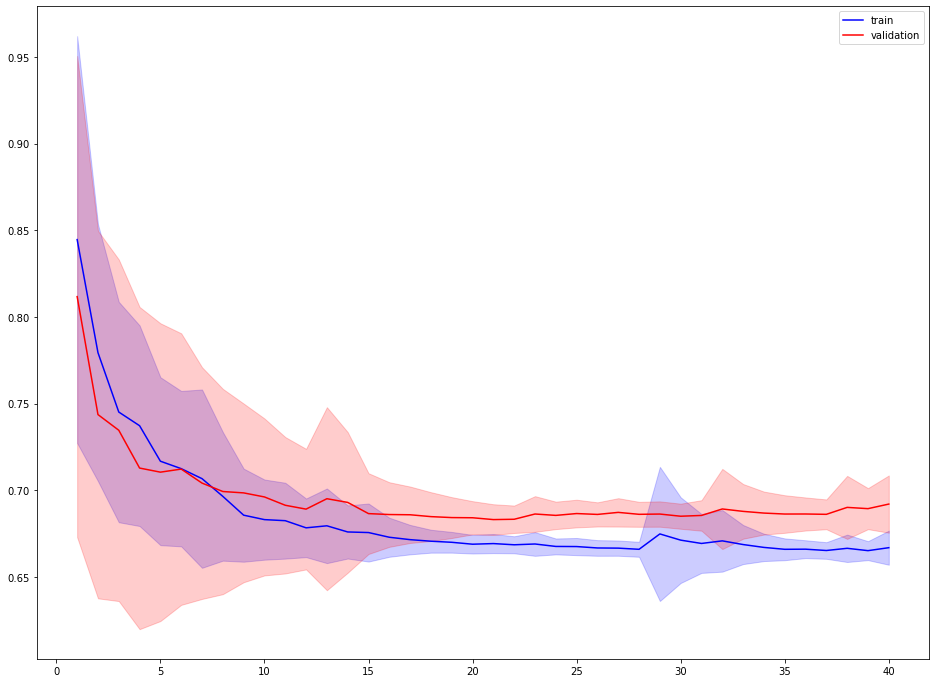

In [27]:
import matplotlib.pyplot as plt
# loss batch size of 5
plt.rcParams["figure.figsize"] = [16,12]

plt.plot(range(1, 41), train_losses_avg, label="train", color='blue')
# plt.errorbar(range(1, 101), train_losses_avg, yerr=train_losses_std, color='blue')
plt.fill_between(range(1, 41), train_losses_avg+train_losses_std, train_losses_avg-train_losses_std, alpha=0.2, color='blue')

plt.plot(range(1, 41), val_losses_avg, label="validation", color='red')
# plt.errorbar(range(1, 101), val_losses_avg, yerr=val_losses_std, color='red')
plt.fill_between(range(1, 41), val_losses_avg+val_losses_std, val_losses_avg-val_losses_std, alpha=0.2, color='red')

plt.legend(loc="best")